# **STROKE PREDICTION - BINARY CLASSIFICATION**

Dataset from kaggle : https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

Attribute Information
1. id: unique identifier
2. gender: "Male", "Female" or "Other"
3. age: age of the patient
4. hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension
5. heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease
6. ever_married: "No" or "Yes"
7. work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"
8. Residence_type: "Rural" or "Urban"
9. avg_glucose_level: average glucose level in blood
10. bmi: body mass index
11. smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*
12. stroke: 1 if the patient had a stroke or 0 if not
*Note: "Unknown" in smoking_status means that the information is unavailable for this patient 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn import preprocessing
from sklearn.model_selection import KFold,cross_val_score, RepeatedStratifiedKFold,StratifiedKFold, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay,RocCurveDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import missingno as msno

import warnings
warnings.filterwarnings("ignore")

**1. Load Data**

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


**2. EDA**

In [3]:
col_inspect = ['gender', 
               'hypertension',	
               'heart_disease',	
               'ever_married',	
               'work_type',	
               'Residence_type',	
               'smoking_status',	
               'stroke']

for col in col_inspect:
  print('---', col, '---')
  c = df[col].value_counts(dropna=False)
  p = df[col].value_counts(dropna=False, normalize=True)
  print(pd.concat([c,p], axis=1, keys=['counts', '%']))
  print('-----')

--- gender ---
        counts         %
Female    2994  0.585910
Male      2115  0.413894
Other        1  0.000196
-----
--- hypertension ---
   counts         %
0    4612  0.902544
1     498  0.097456
-----
--- heart_disease ---
   counts         %
0    4834  0.945988
1     276  0.054012
-----
--- ever_married ---
     counts         %
Yes    3353  0.656164
No     1757  0.343836
-----
--- work_type ---
               counts         %
Private          2925  0.572407
Self-employed     819  0.160274
children          687  0.134442
Govt_job          657  0.128571
Never_worked       22  0.004305
-----
--- Residence_type ---
       counts         %
Urban    2596  0.508023
Rural    2514  0.491977
-----
--- smoking_status ---
                 counts         %
never smoked       1892  0.370254
Unknown            1544  0.302153
formerly smoked     885  0.173190
smokes              789  0.154403
-----
--- stroke ---
   counts         %
0    4861  0.951272
1     249  0.048728
-----


There are some findings:
1. Data is not balanced against the target, stroke or no stroke. Approximately 95% "no" compared to 5% "stroke"
2. There is 1 row of data with the category "other", this data will be deleted because it is not clear
3. Hypertension and heart disease also have a significant difference between “yes” or “no” with the highest ratio being “no”. It could be that both are positively correlated with the target stroke.

In [4]:
df.drop(df.index[df['gender'] == 'Other'], inplace=True)
df = df.reset_index(drop = True)

In [5]:
df.isnull().sum().sort_values(ascending=False)

bmi                  201
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
smoking_status         0
stroke                 0
dtype: int64

In [6]:
df.dropna(inplace=True)

The bmi column has 201 empty data, because the number is not too much compared to the whole data, this empty data will be processed later during preprocessing modeling

In [7]:
df.duplicated().sum()

0

No duplicate data

**Bivarate Analysis**

Categorical features

In [8]:
col_inspect2 = ['gender', 
               'hypertension',	
               'heart_disease',	
               'ever_married',	
               'work_type',	
               'Residence_type',	
               'smoking_status']

print('---- feature and target relationship ----')
print()
for col in col_inspect2:
  if col =='gender':
    print ('People with '+col+ f' female has a probability of {round(df[df[col]=="Female"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' male has a probability of {round(df[df[col]=="Male"]["stroke"].mean()*100,2)} % get a stroke')
    print()
    print('-------------------------------')
  elif col =='ever_married':
    print ('People with '+col+ f' yes has a probability of {round(df[df[col]=="Yes"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' no has a probability of {round(df[df[col]=="No"]["stroke"].mean()*100,2)} % get a stroke')
    print()
    print('-------------------------------')
  elif col =='work_type':
    print ('People with '+col+ f' Private has a probability of {round(df[df[col]=="Private"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' Self-employed has a probability of {round(df[df[col]=="Self-employed"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' Govt_job has a probability of {round(df[df[col]=="Govt_job"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' Never_worked has a probability of {round(df[df[col]=="Never_worked"]["stroke"].mean()*100,2)} % get a stroke')
    print()
    print('-------------------------------')
  elif col =='Residence_type':
    print ('People with '+col+ f' urban has a probability of {round(df[df[col]=="Urban"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' rural has a probability of {round(df[df[col]=="Rural"]["stroke"].mean()*100,2)} % get a stroke')
    print()
    print('-------------------------------')
  elif col =='smoking_status':
    print ('People with '+col+ f' never smoked has a probability of {round(df[df[col]=="never smoked"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' unknown has a probability of {round(df[df[col]=="Unknown"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' formerly smoked has a probability of {round(df[df[col]=="formerly smoked"]["stroke"].mean()*100,2)} % get a stroke')
    print ('People with '+col+ f' smokes has a probability of {round(df[df[col]=="smokes"]["stroke"].mean()*100,2)} % get a stroke')
    print()
    print('-------------------------------')
  else:
    print ('People with '+col+ f' has a probability of {round(df[df[col]==1]["stroke"].mean()*100,2)} % get a stroke')
    print ('People without '+col+ f' has a probability of {round(df[df[col]==0]["stroke"].mean()*100,2)} % get a stroke')
    print()
    print('-------------------------------')

---- feature and target relationship ----

People with gender female has a probability of 4.14 % get a stroke
People with gender male has a probability of 4.43 % get a stroke

-------------------------------
People with hypertension has a probability of 13.3 % get a stroke
People without hypertension has a probability of 3.34 % get a stroke

-------------------------------
People with heart_disease has a probability of 16.46 % get a stroke
People without heart_disease has a probability of 3.62 % get a stroke

-------------------------------
People with ever_married yes has a probability of 5.81 % get a stroke
People with ever_married no has a probability of 1.35 % get a stroke

-------------------------------
People with work_type Private has a probability of 4.52 % get a stroke
People with work_type Self-employed has a probability of 6.84 % get a stroke
People with work_type Govt_job has a probability of 4.44 % get a stroke
People with work_type Never_worked has a probability of 0.0 %

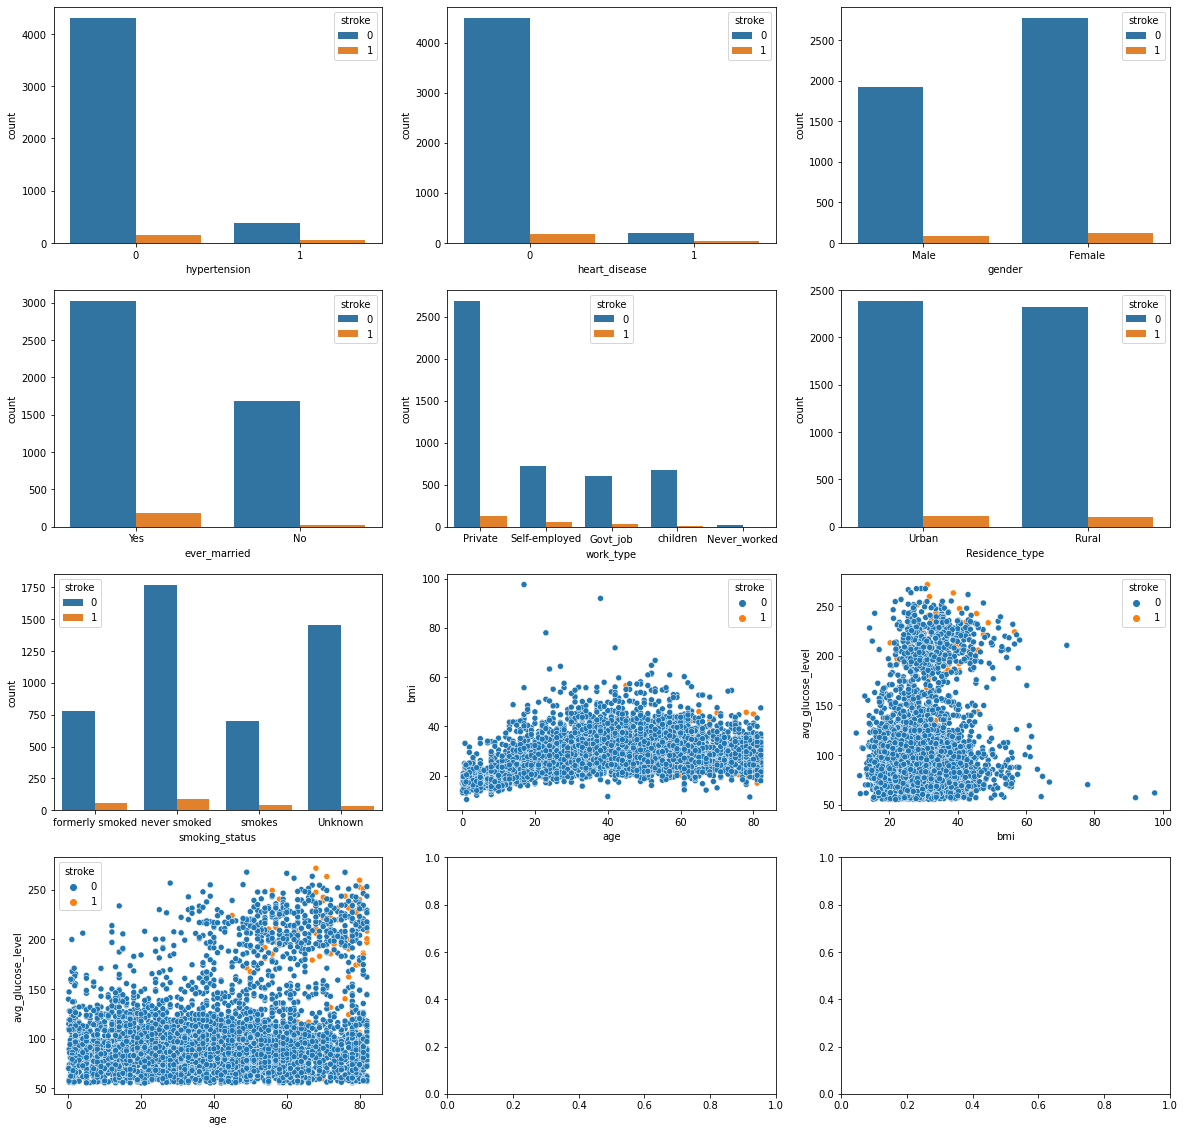

In [9]:
fig, ax = plt.subplots(4, 3, figsize=(20, 20), sharex=False)

ax0 = sns.countplot(data=df, x="hypertension", hue='stroke', ax=ax[0,0])
ax1 = sns.countplot(data=df, x="heart_disease", hue='stroke', ax=ax[0,1])
ax2 = sns.countplot(data=df, x="gender", hue='stroke', ax=ax[0,2])
ax3 = sns.countplot(data=df, x="ever_married", hue='stroke', ax=ax[1,0])
ax4 = sns.countplot(data=df, x="work_type", hue='stroke', ax=ax[1,1])
ax5 = sns.countplot(data=df, x="Residence_type", hue='stroke', ax=ax[1,2])
ax6 = sns.countplot(data=df, x="smoking_status", hue='stroke', ax=ax[2,0])
ax7 = sns.scatterplot(data=df, x="age", y='bmi',hue='stroke', ax=ax[2,1])
ax8 = sns.scatterplot(data=df, x="bmi", y='avg_glucose_level',hue='stroke', ax=ax[2,2])
ax9 = sns.scatterplot(data=df, x="age", y='avg_glucose_level',hue='stroke', ax=ax[3,0])

**Correlation**

In [10]:
numeric_col = ['age', 'avg_glucose_level', 'bmi','stroke']

df[numeric_col].corr().style.background_gradient(cmap='YlOrRd')

,age,avg_glucose_level,bmi,stroke
age,1.000000,0.236000,0.333314,0.232313
avg_glucose_level,0.236000,1.000000,0.175672,0.138984
bmi,0.333314,0.175672,1.000000,0.042341
stroke,0.232313,0.138984,0.042341,1.000000


**3. Modelling ML**

Feature Engineering - One hot Encoding & Label Encoding

In [11]:
df_model = df.copy()

In [12]:
df_onehot = pd.get_dummies(df[['ever_married']], prefix="married", prefix_sep="_")
df_onehot2 = pd.get_dummies(df[['gender']], prefix="gender", prefix_sep="_")
df_onehot3 = pd.get_dummies(df[['Residence_type']], prefix="residence", prefix_sep="_")
df_final_onehot = df_onehot.join([df_onehot2, df_onehot3])

In [13]:
label_encoder = preprocessing.LabelEncoder()

label_cols = ["work_type", "smoking_status"]
for col in label_cols:
    df_model[col]= label_encoder.fit_transform(df_model[col])

In [14]:
df_model = df_final_onehot.join(df_model)

In [15]:
df_model.drop(columns=['id', 'ever_married', 'gender', 'Residence_type'], inplace=True)

In [16]:
# mean_value = df_model['bmi'].mean()
# df_model['bmi'].fillna(value = mean_value, inplace = True) 

In [17]:
df_model

,married_No,married_Yes,gender_Female,gender_Male,residence_Rural,residence_Urban,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,1,0,1,0,1,67.0,0,1,2,228.69,36.6,1,1
2,0,1,0,1,1,0,80.0,0,1,2,105.92,32.5,2,1
3,0,1,1,0,0,1,49.0,0,0,2,171.23,34.4,3,1
4,0,1,1,0,1,0,79.0,1,0,3,174.12,24.0,2,1
5,0,1,0,1,0,1,81.0,0,0,2,186.21,29.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5103,1,0,1,0,1,0,13.0,0,0,4,103.08,18.6,0,0
5105,0,1,1,0,0,1,81.0,0,0,3,125.20,40.0,2,0
5106,0,1,1,0,1,0,35.0,0,0,3,82.99,30.6,2,0
5107,0,1,0,1,1,0,51.0,0,0,2,166.29,25.6,1,0


In [18]:
df_model.corr().style.background_gradient(cmap='YlOrRd')

,married_No,married_Yes,gender_Female,gender_Male,residence_Rural,residence_Urban,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
married_No,1.000000,-1.000000,-0.036380,0.036380,0.004707,-0.004707,-0.680742,-0.162350,-0.111203,0.358059,-0.151657,-0.341553,-0.264598,-0.105051
married_Yes,-1.000000,1.000000,0.036380,-0.036380,-0.004707,0.004707,0.680742,0.162350,0.111203,-0.358059,0.151657,0.341553,0.264598,0.105051
gender_Female,-0.036380,0.036380,1.000000,-1.000000,-0.004351,0.004351,0.030280,-0.021811,-0.082950,-0.058725,-0.053161,0.026164,0.059837,-0.006904
gender_Male,0.036380,-0.036380,-1.000000,1.000000,0.004351,-0.004351,-0.030280,0.021811,0.082950,0.058725,0.053161,-0.026164,-0.059837,0.006904
residence_Rural,0.004707,-0.004707,-0.004351,0.004351,1.000000,-1.000000,-0.010795,0.001140,0.002409,0.005455,0.007441,0.000293,-0.013739,-0.005988
residence_Urban,-0.004707,0.004707,0.004351,-0.004351,-1.000000,1.000000,0.010795,-0.001140,-0.002409,-0.005455,-0.007441,-0.000293,0.013739,0.005988
age,-0.680742,0.680742,0.030280,-0.030280,-0.010795,0.010795,1.000000,0.274395,0.257104,-0.367033,0.236000,0.333314,0.275481,0.232313
hypertension,-0.162350,0.162350,-0.021811,0.021811,0.001140,-0.001140,0.274395,1.000000,0.115978,-0.052760,0.180614,0.167770,0.110788,0.142503
heart_disease,-0.111203,0.111203,-0.082950,0.082950,0.002409,-0.002409,0.257104,0.115978,1.000000,-0.030381,0.154577,0.041322,0.055221,0.137929
work_type,0.358059,-0.358059,-0.058725,0.058725,0.005455,-0.005455,-0.367033,-0.052760,-0.030381,1.000000,-0.050558,-0.304924,-0.310927,-0.033763


Modelling

In [19]:
y = df_model[df_model.columns[-1]]
x = df_model.drop(df_model.columns[-1], axis=1)

In [20]:
# # sm = SMOTE(random_state=2)
# x, y = sm.fit_resample(x, y)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)

In [22]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

x_train_scaled = ss.fit_transform(X_train)
x_test_scaled = ss.transform(X_test)

In [23]:
sm = SMOTE(random_state=2)
x_train_res, y_train_res = sm.fit_resample(x_train_scaled, y_train.ravel())

In [24]:
unique, counts = np.unique(y_train_res, return_counts=True)
dict(zip(unique, counts))

{0: 3770, 1: 3770}

In [25]:
models = pd.DataFrame(columns=['Model', 'Precision', 'Recall', 'Accuracy', 'F1-Score'])

logistic Reg

In [26]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(max_iter=1000) #model
log_reg_model.fit(x_train_res,y_train_res) 

train_predictions_log = log_reg_model.predict(x_train_res) #train the model
test_predictions_log = log_reg_model.predict(x_test_scaled) #test the model

precision = precision_score(y_test,test_predictions_log)
recall = recall_score(y_test,test_predictions_log)
accu = accuracy_score(y_test,test_predictions_log)
f1_sc = f1_score(y_test,test_predictions_log) 

print('Logistic regression model evaluation:')
print('Precision: ', precision)
print('Recall: ', recall)
print('\nAccuracy: ',accu)
print('f1_score: ', f1_sc)

new_row = {"Model": "Logistic Regression","Precision": precision, "Recall": recall, "Accuracy": accu, "F1-Score": f1_sc}
models = models.append(new_row, ignore_index=True)

Logistic regression model evaluation:
Precision:  0.16296296296296298
Recall:  0.8301886792452831

Accuracy:  0.7606924643584522
f1_score:  0.27244582043343657


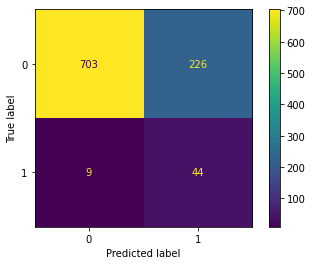

In [27]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(log_reg_model,x_test_scaled,y_test)

In [28]:
from sklearn.metrics import plot_confusion_matrix, classification_report

print(classification_report(y_test,test_predictions_log))

print('Accuracy Score: ',accuracy_score(y_test,test_predictions_log))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86       929
           1       0.16      0.83      0.27        53

    accuracy                           0.76       982
   macro avg       0.58      0.79      0.56       982
weighted avg       0.94      0.76      0.83       982

Accuracy Score:  0.7606924643584522


Random Forest

In [29]:
from sklearn.ensemble import RandomForestClassifier
random_forest_model = RandomForestClassifier(random_state=42) #model
random_forest_model.fit(x_train_res,y_train_res) 

train_predictions_rf = random_forest_model.predict(x_train_res) #train the model
test_predictions_rf = random_forest_model.predict(x_test_scaled) #test the model

precision = precision_score(y_test,test_predictions_rf)
recall = recall_score(y_test,test_predictions_rf)
accu = accuracy_score(y_test,test_predictions_rf)
f1_sc = f1_score(y_test,test_predictions_rf) 

print('Random Forest Classifier model evaluation:')
print('Precision: ', precision)
print('Recall: ', recall)
print('\nAccuracy: ',accu)
print('f1_score: ', f1_sc)

new_row = {"Model": "Random Forest Classifier","Precision": precision, "Recall": recall, "Accuracy": accu, "F1-Score": f1_sc}
models = models.append(new_row, ignore_index=True)

Random Forest Classifier model evaluation:
Precision:  0.07894736842105263
Recall:  0.05660377358490566

Accuracy:  0.9134419551934827
f1_score:  0.06593406593406592


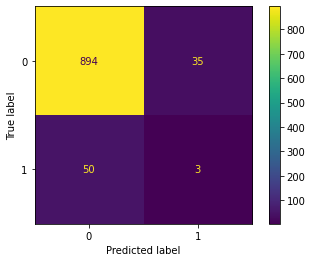

In [30]:
plot_confusion_matrix(random_forest_model,x_test_scaled,y_test)

In [31]:
print(classification_report(y_test,test_predictions_rf))

print('Accuracy Score: ',accuracy_score(y_test,test_predictions_rf))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95       929
           1       0.08      0.06      0.07        53

    accuracy                           0.91       982
   macro avg       0.51      0.51      0.51       982
weighted avg       0.90      0.91      0.91       982

Accuracy Score:  0.9134419551934827


Decission Tree

In [32]:
from sklearn.tree import DecisionTreeClassifier
dtc_model = DecisionTreeClassifier() #model
dtc_model.fit(x_train_scaled,y_train) 

train_predictions_dtc = dtc_model.predict(x_train_scaled) #train the model
test_predictions_dtc = dtc_model.predict(x_test_scaled) #test the model

precision = precision_score(y_test,test_predictions_dtc)
recall = recall_score(y_test,test_predictions_dtc)
accu = accuracy_score(y_test,test_predictions_dtc)
f1_sc = f1_score(y_test,test_predictions_dtc) 

print('Decision Tree Classifier model evaluation:')
print('Precision: ', precision)
print('Recall: ', recall)
print('\nAccuracy: ',accu)
print('f1_score: ', f1_sc)

new_row = {"Model": "Decision Tree Classifier","Precision": precision, "Recall": recall, "Accuracy": accu, "F1-Score": f1_sc}
models = models.append(new_row, ignore_index=True)

Decision Tree Classifier model evaluation:
Precision:  0.2037037037037037
Recall:  0.20754716981132076

Accuracy:  0.9134419551934827
f1_score:  0.20560747663551404


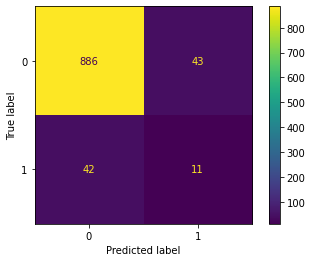

In [33]:
plot_confusion_matrix(dtc_model,x_test_scaled,y_test)

In [34]:
print(classification_report(y_test,test_predictions_dtc))

print('Accuracy Score: ',accuracy_score(y_test,test_predictions_dtc))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       929
           1       0.20      0.21      0.21        53

    accuracy                           0.91       982
   macro avg       0.58      0.58      0.58       982
weighted avg       0.91      0.91      0.91       982

Accuracy Score:  0.9134419551934827


In [35]:
models

,Model,Precision,Recall,Accuracy,F1-Score
0,Logistic Regression,0.162963,0.830189,0.760692,0.272446
1,Random Forest Classifier,0.078947,0.056604,0.913442,0.065934
2,Decision Tree Classifier,0.203704,0.207547,0.913442,0.205607


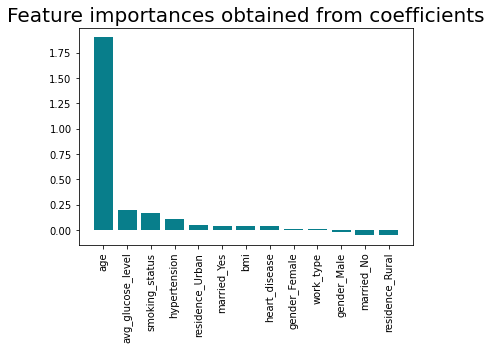

In [47]:

importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': log_reg_model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()